In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
from tqdm.notebook import tqdm_notebook
import warnings
import time
from requests import get
warnings.filterwarnings("ignore")
import nltk


from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPRegressor, BernoulliRBM


In [2]:
seinfeld = pd.read_csv('seinfeld_episode_rankings.csv')

In [3]:
seinfeld

,Title,Plot,Quotability/cultural impact,Laughs,Total score,IMDb rating,IMDb rank,Notes,Season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
seinfeld.columns=['title','plot','quotability','laughs','total_score','imdb_rating','imdb_rank','notes','season','episode']

In [5]:
#seinfeld=seinfeld[seinfeld.season<7]

In [6]:
seinfeld.sort_values('total_score',ascending=False)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
77,the_marine_biologist,5.0,9.0,52.0,101.739130,9.2,5.0,NaN,5.0,14.0
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,10.0,"""Shrinkage""",5.0,20.0
103,the_fusilli_jerry,4.0,10.0,49.0,85.217391,8.7,24.0,assman,6.0,19.0
50,the_contest,5.0,10.0,31.0,67.391304,9.6,1.0,first appearance of Estelle.,4.0,11.0
94,the_race,5.0,9.0,32.0,62.608696,8.9,10.0,NaN,6.0,10.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
scripts = pd.read_csv('seinfeld_data/scripts.csv')

In [8]:
episodes = pd.read_csv('seinfeld_data/episode_info.csv')

In [9]:
episodes = episodes.drop(columns='Unnamed: 0')

In [10]:
episodes.Title = episodes.Title.astype(str)

In [11]:
episodes.Title = episodes.Title.str.lower().str.replace(' ','_').str.replace(',','')

In [12]:
scripts = scripts.drop(columns='Unnamed: 0')

In [13]:
scripts[0:211].SEID = scripts.SEID.str.replace('S01E01','S01E00')
scripts[0:211].EpisodeNo = 0.0

In [14]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [15]:
episodes.SEID[0] = 'S01E00'
episodes.EpisodeNo[0] = 0.0

In [16]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season,line
0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0,JERRY: Do you know what this is all about? Do ...
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,GEORGE,Are you through?,1.0,S01E01,1.0,GEORGE: Are you through?
3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0,"JERRY: You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [17]:
scripts.Character=scripts.Character.str.replace(r"\(.*\)","")

In [18]:
line_count=scripts.Character.value_counts().head(475)

In [19]:
scripts.Character.str.strip().value_counts().head(10)

JERRY       14905
GEORGE       9781
ELAINE       8073
KRAMER       6723
NEWMAN        649
MORTY         507
HELEN         474
FRANK         438
SUSAN         382
[Setting      293
Name: Character, dtype: int64

In [20]:
episodes["SEID"] = episodes.SEID.astype(str)
scripts["SEID"] = scripts.SEID.astype(str)

In [21]:
pd.merge(episodes, right=scripts, on='SEID')

,Season_x,EpisodeNo_x,Title,AirDate,Writers,Director,SEID,Character,Dialogue,EpisodeNo_y,Season_y,line
0,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,JERRY,Do you know what this is all about? Do you kno...,1.0,1.0,JERRY: Do you know what this is all about? Do ...
1,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,1.0,"JERRY: (pointing at Georges shirt) See, to me,..."
2,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,GEORGE,Are you through?,1.0,1.0,GEORGE: Are you through?
3,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,JERRY,"You do of course try on, when you buy?",1.0,1.0,"JERRY: You do of course try on, when you buy?"
4,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,1.0,"GEORGE: Yes, it was purple, I liked it, I dont..."
...,...,...,...,...,...,...,...,...,...,...,...,...
54611,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,9.0,JERRY: Grand theft auto - don't steal any of m...
54612,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,PRISONER 3,You suck - I'm gonna cut you.,23.0,9.0,PRISONER 3: You suck - I'm gonna cut you.
54613,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,"Hey, I don't come down to where you work, and ...",23.0,9.0,"JERRY: Hey, I don't come down to where you wor..."
54614,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,9.0,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [22]:
seinfeld.title[0] = 'good_news_bad_news'

In [23]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
episodes.columns = episodes.columns.str.lower()


In [25]:
seinfeld.title = seinfeld.title.str.replace(r"\d:\d*","").str.strip().str.replace(' ','_').str.lower()

In [26]:
seinfeld[seinfeld.title=="the_cafe"]

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
23,the_cafe,4.0,6.0,9.5,9.913043,8.4,58.0,Babu’s first appearance,3.0,7.0


In [27]:
episodes[episodes.title=='the_cafe']

,season,episodeno,title,airdate,writers,director,seid
23,3.0,7.0,the_cafe,"November 6, 1991",Tom Leopold,Tom Cherones,S03E07


In [28]:
episodes.title.to_csv('titles.csv')

In [29]:
seinfeld=pd.merge(seinfeld, right = episodes, on='title')

In [30]:
seinfeld.sort_values('total_score',ascending=True).head(10)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
173,the_finale,NaN,NaN,NaN,0.0,7.8,158.0,NaN,9.0,21.0,9.0,23.0,"May 14, 1998",Larry David,Andy Ackerman,S09E23
130,the_invitations,NaN,NaN,NaN,0.0,8.6,35.0,NaN,7.0,24.0,7.0,24.0,"May 16, 1996",Larry David,Andy Ackerman,S07E24
131,the_foundation,NaN,NaN,NaN,0.0,8.1,112.0,NaN,7.0,25.0,8.0,1.0,"September 19, 1996","Alec Berg, Jeff Schaffer",Andy Ackerman,S08E01
132,the_soul_mate,NaN,NaN,NaN,0.0,8.0,135.0,NaN,8.0,1.0,8.0,2.0,"September 26, 1996",Peter Mehlman,Andy Ackerman,S08E02
133,the_bizarro_jerry,NaN,NaN,NaN,0.0,9.1,6.0,NaN,8.0,2.0,8.0,3.0,"October 3, 1996",David Mandel,Andy Ackerman,S08E03
134,the_little_kicks,NaN,NaN,NaN,0.0,8.9,10.0,NaN,8.0,3.0,8.0,4.0,"October 10, 1996",Spike Feresten,Andy Ackerman,S08E04
135,the_package,NaN,NaN,NaN,0.0,8.6,35.0,NaN,8.0,4.0,8.0,5.0,"October 17, 1996",Jennifer Crittenden,Andy Ackerman,S08E05
136,the_fatigues,NaN,NaN,NaN,0.0,8.0,135.0,NaN,8.0,5.0,8.0,6.0,"October 31, 1996","Gregg Kavet, Andy Robin",Andy Ackerman,S08E06
137,the_checks,NaN,NaN,NaN,0.0,8.1,112.0,NaN,8.0,6.0,8.0,7.0,"November 7, 1996","Steve O'Donnell and Tom Gammill, Max Pross",Andy Ackerman,S08E07
129,the_wait_out,NaN,NaN,NaN,0.0,8.3,79.0,NaN,7.0,23.0,7.0,23.0,"May 9, 1996",Peter Mehlman,Andy Ackerman,S07E23


In [31]:
seinfeld.director = seinfeld.director.replace('David&nbsp; Steinberg','David Steinberg')

In [32]:
seinfeld.director.value_counts()

Andy Ackerman         87
Tom Cherones          80
David Steinberg        2
David Owen Trainor     2
Art Wolff              1
Joshua White           1
Jason Alexander        1
Name: director, dtype: int64

In [33]:
scripts.Character = scripts.Character.str.strip()
scripts.Character = scripts.Character.replace(r'babu.*|BABU.*','BABU')

In [34]:
scripts.Character.nunique()

1214

In [35]:
scripts=scripts[~scripts.Character.str.contains(r'\(\*|[a-z]|http')]

In [36]:
#scripts = scripts.drop(index=scripts[(scripts.Character==r'http')|(scripts.Dialogue.isnull())].index.tolist())
grouped_scripts=scripts.groupby('SEID')

In [37]:
seinfeld.writers.value_counts()

Larry David                                                                                                                                              29
Larry David, Jerry Seinfeld                                                                                                                              15
Larry Charles                                                                                                                                            15
Peter Mehlman                                                                                                                                            14
Gregg Kavet, Andy Robin                                                                                                                                  10
Tom Gammill, Max Pross                                                                                                                                   10
Alec Berg, Jeff Schaffer                                        

In [38]:
scripts = scripts.drop(index=scripts[scripts.Character=='http'].index.tolist())

In [39]:
seinfeld_prepped=seinfeld.drop(columns=['season_x','episode','notes','title','seid'])

In [40]:
#seinfeld_prepped.airdate=pd.to_datetime(seinfeld_prepped.airdate)
#seinfeld_prepped = seinfeld_prepped.set_index('airdate').sort_values(by='airdate')

In [41]:
seinfeld_prepped = pd.get_dummies(seinfeld_prepped, columns=['writers','director'], drop_first=True)

In [42]:
train=seinfeld_prepped[seinfeld_prepped.season_y<4]
validate=seinfeld_prepped[seinfeld_prepped.season_y>3]

In [43]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,airdate,"writers_Alec Berg, Jeff Schaffer",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,166.0,1.0,0.0,"July 5, 1989",0,...,0,0,0,0,1,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,173.0,1.0,3.0,"June 14, 1990",0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,160.0,1.0,1.0,"May 31, 1990",0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,166.0,1.0,2.0,"June 7, 1990",0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,168.0,1.0,4.0,"June 21, 1990",0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,160.0,2.0,1.0,"January 16, 1991",0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,149.0,2.0,2.0,"January 30, 1991",0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,79.0,2.0,3.0,"February 6, 1991",0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,58.0,2.0,4.0,"February 13, 1991",0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,149.0,2.0,5.0,"April 4, 1991",0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
x_train = train.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_train = train.total_score
x_validate = validate.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_validate = validate.total_score

In [45]:
regr = MLPRegressor( max_iter=1500).fit(x_train, y_train)

In [46]:
predictions=pd.DataFrame(regr.predict(x_validate),columns=['predict'])
regr.score(x_validate,y_validate)

-0.8922457667014367

In [47]:
y_validate=pd.concat([y_validate.reset_index(),predictions],axis=1)

<AxesSubplot:>

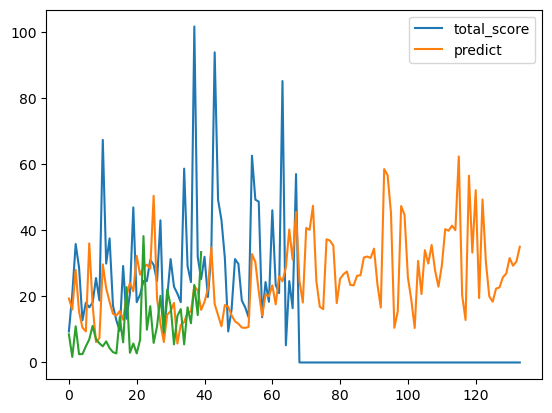

In [48]:
y_validate.drop(columns='index').plot()
y_train.plot()

<AxesSubplot:>

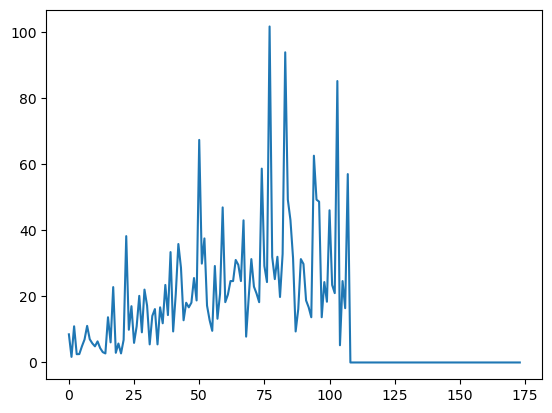

In [49]:
seinfeld.total_score.plot()

In [50]:
seinfeld_prepped.airdate = pd.to_datetime(seinfeld_prepped.airdate)
x=seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score']).set_index('airdate')
x_train = seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score'])[seinfeld_prepped.total_score > 0].set_index('airdate')
y_train = seinfeld_prepped.total_score[seinfeld_prepped.total_score > 0]
regr = MLPRegressor( max_iter=150,solver= 'lbfgs').fit(x_train,y_train)
mlp_predictions=pd.DataFrame(regr.predict(x),columns=['predict'])
y_mlp=pd.concat([y_train,mlp_predictions],axis=1)

<AxesSubplot:>

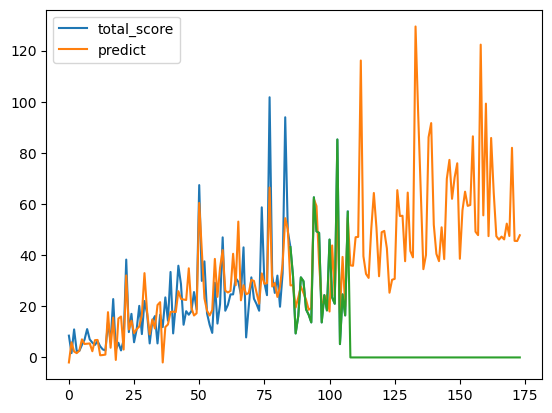

In [51]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()


In [52]:
seinfeld_prepped.corr()

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,"writers_Alec Berg, Jeff Schaffer","writers_Alec Berg, Jeff Schaffer, David Mandel",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
plot,1.000000,0.393511,0.345006,0.555023,0.392301,-0.391529,0.146066,-0.082795,-0.014435,NaN,...,-0.105069,0.161576,-0.093171,-0.041894,0.034202,-0.093171,-0.041894,-0.093171,-0.093171,0.069081
quotability,0.393511,1.000000,0.562702,0.679188,0.425403,-0.404419,0.492247,0.277078,0.087510,NaN,...,0.075343,0.102275,0.050049,-0.151503,-0.002176,-0.054402,-0.151503,-0.002176,-0.002176,-0.077998
laughs,0.345006,0.562702,1.000000,0.913272,0.544550,-0.510399,0.624208,0.318307,0.136773,NaN,...,-0.012693,0.150749,0.214429,-0.117570,-0.114585,-0.003145,-0.106260,-0.050905,-0.109278,-0.199962
total_score,0.555023,0.679188,0.913272,1.000000,0.279631,-0.231786,-0.296039,0.101987,-0.039981,-0.083647,...,0.014053,0.201247,0.023428,-0.038281,-0.023557,-0.043279,-0.024761,-0.009642,-0.030514,0.365488
imdb_rating,0.392301,0.425403,0.544550,0.279631,1.000000,-0.956025,0.225811,0.165351,0.045695,0.021098,...,-0.023232,0.106660,-0.003481,-0.096063,-0.131979,-0.004938,-0.017956,-0.058552,0.051589,-0.106283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
director_David Owen Trainor,-0.093171,-0.054402,-0.003145,-0.043279,-0.004938,-0.001307,0.069013,-0.003760,-0.025184,-0.011628,...,-0.026627,-0.008198,-0.008198,-0.011628,-0.008198,1.000000,-0.011628,-0.008198,-0.008198,-0.099479
director_David Steinberg,-0.041894,-0.151503,-0.106260,-0.024761,-0.017956,0.021429,-0.120094,-0.099506,-0.025184,-0.011628,...,-0.026627,-0.008198,-0.008198,-0.011628,-0.008198,-0.011628,1.000000,-0.008198,-0.008198,-0.099479
director_Jason Alexander,-0.093171,-0.002176,-0.050905,-0.009642,-0.058552,0.082283,-0.084674,0.098609,-0.017756,-0.008198,...,-0.018774,-0.005780,-0.005780,-0.008198,-0.005780,-0.008198,-0.008198,1.000000,-0.005780,-0.070139
director_Joshua White,-0.093171,-0.002176,-0.109278,-0.030514,0.051589,-0.070385,-0.084674,-0.070158,-0.017756,-0.008198,...,-0.018774,-0.005780,-0.005780,-0.008198,-0.005780,-0.008198,-0.008198,-0.005780,1.000000,-0.070139


In [53]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [54]:
scripts.SEID.unique().tolist()

['S01E01',
 'S01E02',
 'S01E03',
 'S01E04',
 'S02E01',
 'S02E02',
 'S02E03',
 'S02E04',
 'S02E05',
 'S02E06',
 'S02E07',
 'S02E08',
 'S02E09',
 'S02E10',
 'S02E11',
 'S02E12',
 'S03E01',
 'S03E02',
 'S03E03',
 'S03E04',
 'S03E05',
 'S03E06',
 'S03E07',
 'S03E08',
 'S03E09',
 'S03E10',
 'S03E11',
 'S03E12',
 'S03E13',
 'S03E14',
 'S03E15',
 'S03E16',
 'S03E17',
 'S03E18',
 'S03E19',
 'S03E20',
 'S03E21',
 'S03E22',
 'S03E23',
 'S04E01',
 'S04E02',
 'S04E03',
 'S04E04',
 'S04E05',
 'S04E06',
 'S04E07',
 'S04E08',
 'S04E09',
 'S04E10',
 'S04E11',
 'S04E12',
 'S04E13',
 'S04E14',
 'S04E15',
 'S04E16',
 'S04E17',
 'S04E18',
 'S04E19',
 'S04E20',
 'S04E21',
 'S04E22',
 'S04E23',
 'S04E24',
 'S05E01',
 'S05E02',
 'S05E03',
 'S05E04',
 'S05E05',
 'S05E06',
 'S05E07',
 'S05E08',
 'S05E09',
 'S05E10',
 'S05E11',
 'S05E12',
 'S05E13',
 'S05E14',
 'S05E15',
 'S05E16',
 'S05E17',
 'S05E18',
 'S05E20',
 'S05E21',
 'S05E22',
 'S06E01',
 'S06E02',
 'S06E03',
 'S06E04',
 'S06E05',
 'S06E06',
 'S06E07',

In [55]:
seinfeld.seid.unique().tolist()

['S01E00',
 'S01E03',
 'S01E01',
 'S01E02',
 'S01E04',
 'S02E01',
 'S02E02',
 'S02E03',
 'S02E04',
 'S02E05',
 'S02E06',
 'S02E07',
 'S02E08',
 'S02E09',
 'S02E10',
 'S02E11',
 'S02E12',
 'S03E01',
 'S03E02',
 'S03E03',
 'S03E04',
 'S03E05',
 'S03E06',
 'S03E07',
 'S03E08',
 'S03E09',
 'S03E10',
 'S03E11',
 'S03E12',
 'S03E13',
 'S03E14',
 'S03E15',
 'S03E16',
 'S03E17',
 'S03E18',
 'S03E19',
 'S03E20',
 'S03E21',
 'S03E22',
 'S03E23',
 'S04E01',
 'S04E02',
 'S04E03',
 'S04E04',
 'S04E05',
 'S04E06',
 'S04E07',
 'S04E08',
 'S04E09',
 'S04E10',
 'S04E11',
 'S04E12',
 'S04E13',
 'S04E14',
 'S04E15',
 'S04E16',
 'S04E17',
 'S04E18',
 'S04E19',
 'S04E20',
 'S04E21',
 'S04E22',
 'S04E23',
 'S04E24',
 'S05E01',
 'S05E02',
 'S05E03',
 'S05E04',
 'S05E05',
 'S05E06',
 'S05E07',
 'S05E08',
 'S05E09',
 'S05E10',
 'S05E11',
 'S05E12',
 'S05E13',
 'S05E14',
 'S05E15',
 'S05E16',
 'S05E17',
 'S05E18',
 'S05E20',
 'S05E21',
 'S05E22',
 'S06E01',
 'S06E02',
 'S06E03',
 'S06E04',
 'S06E05',
 'S06E06',

In [56]:
ss = pd.read_csv('seinfeld_scripts.csv')
ss = pd.DataFrame(ss)
ss = ss.drop(columns=['Unnamed: 0'])
ss

,script
0,'JERRY: Do you know what this is all about? Do...
1,"'JERRY: So, Im on line at the supermarket. Two..."
2,"'JERRY: So I move into the centre lane, now I ..."
3,'JERRY: Most men like working on things. Tools...
4,'JERRY: Went out to dinner the other night. Ch...
...,...
169,'GEORGE: I read somewhere that this Brentano's...
170,'ALL: Happy birthday to you.\n ...
171,'JERRY: Cup of tea with lemon.\n ...
172,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [57]:
seinfeld['script'] = ss
seinfeld.script = seinfeld.script.astype(str)

In [58]:
seinfeld.script = seinfeld.script.str.replace(r"(S\d+E\d+|,\s\d*\s{2,}|Name:.*)|\(\'|(?<=\n)\d+","")

In [59]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two..."
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ..."
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [60]:
class lemmatizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, df):
        return [self.wnl.lemmatize(word) for word in word_tokenize(df)]

vectorizer = CountVectorizer( max_df=0.95, min_df=0.05, ngram_range=(1,2),
                             tokenizer=lemmatizer(), lowercase=True, stop_words='english',
                             token_pattern = r'\w+')

vectorizer.fit(seinfeld['script'])
count_vector = vectorizer.transform(seinfeld['script'])

bow_data = count_vector.toarray()
bow_data = pd.DataFrame(bow_data, columns=vectorizer.get_feature_names())
bow_data.head()

,!,! !,! (,! ...,! george,! jerry,','d,'elaine,'elaine :,...,woman,y,y ...,ya,yeah,"yeah ,",yeah .,yes,yo,yo ...
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,3,2,1,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid,script
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0,1.0,0.0,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,'JERRY: Do you know what this is all about? Do...
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0,1.0,3.0,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03,"'JERRY: So, Im on line at the supermarket. Two..."
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0,1.0,1.0,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01,"'JERRY: So I move into the centre lane, now I ..."
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0,1.0,2.0,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02,'JERRY: Most men like working on things. Tools...
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0,1.0,4.0,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04,'JERRY: Went out to dinner the other night. Ch...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,the_bookstore,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,9.0,17.0,9.0,17.0,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17,'GEORGE: I read somewhere that this Brentano's...
170,the_frogger,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,9.0,18.0,9.0,18.0,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18,'ALL: Happy birthday to you.\n ...
171,the_maid,NaN,NaN,NaN,0.000000,8.0,135.0,NaN,9.0,19.0,9.0,19.0,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19,'JERRY: Cup of tea with lemon.\n ...
172,the_puerto_rican_day,NaN,NaN,NaN,0.000000,7.9,149.0,NaN,9.0,20.0,9.0,20.0,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20,"'GEORGE: Man, I'm starving.\n ELAINE: How c..."


In [62]:
x_train, x_test, y_train, y_test = train_test_split(bow_data,
                                                  seinfeld['total_score'],
                                                  test_size=0.2, random_state=123)

In [63]:
train=seinfeld[seinfeld.season_x<6].total_score

In [64]:
regr = MLPRegressor( max_iter=500,solver= 'lbfgs').fit(bow_data[:85],train)
mlp_predictions=pd.DataFrame(regr.predict(bow_data),columns=['predict'])
y_mlp=pd.concat([train,mlp_predictions],axis=1)

<AxesSubplot:>

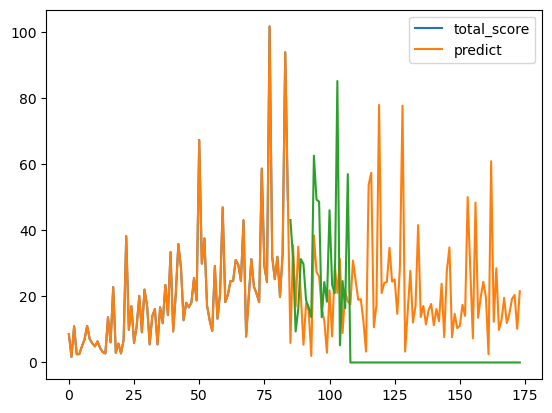

In [65]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()

In [71]:
mse = mean_squared_error(train,y_mlp.predict[:85])
rmse = mse**.5
rmse

0.00015040520413558834

In [ ]:
#y_mlp.total_score = y_mlp.total_score.replace(np.NaN, 0)

In [72]:
y_mlp.total_score.isna().sum()

89

<AxesSubplot:>

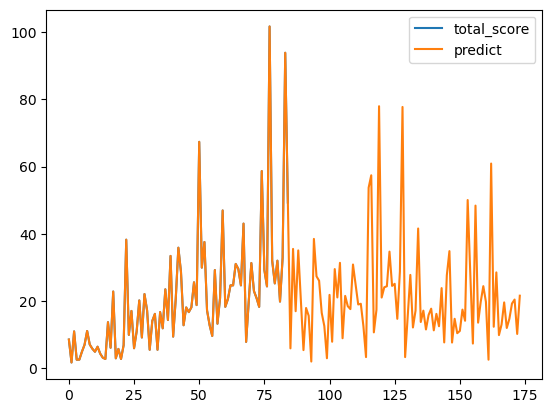

In [73]:
y_mlp.plot()

In [74]:
y_mlp.head(50)

,total_score,predict
0,8.521739,8.521822
1,1.695652,1.695730
2,10.956522,10.956477
3,2.510870,2.510823
4,2.543478,2.543644
5,4.891304,4.891429
6,6.956522,6.956004
7,11.086957,11.087119
8,7.043478,7.043383
9,5.782609,5.782816


In [ ]:
seinfeld.script.to_csv('seinfeld_scripts.csv')

In [ ]:
scripts

In [ ]:
seinfeld[seinfeld.total_score>40]

In [ ]:
headers = {'User-Agent': 'Codeup Data Science'} # Some websites don't accept the pyhon-requests default user-agent
url = f'https://seinfeld.fandom.com/wiki/List_of_Seinfeld_episodes'
response = get(url, headers=headers)
soup = bs(response.content, 'html.parser')
tables = soup.find_all('table')
tables

In [ ]:
rows = []

# Find all `tr` tags
for table in tables[:-1]:
    data_rows = table.find_all('tr')
    for row in data_rows:
        value = row.find_all('td')
        beautified_value = [ele.text.strip() for ele in value]
        # Remove data arrays that are empty
        if len(beautified_value) == 0:
            continue
        rows.append(beautified_value)
rows = rows[1::2]

In [ ]:
rows.insert(38,"Coming from an outing to a flea market in Westchester, Elaine and George damage Jerry's car when George drives over a large pothole. When they get to his apartment they conveniently find a parking space right in front of Jerry's building. As George tries to back in however, someone tries to take the spot by driving in nose-first. Neither car is able to park, and an all-day argument ensues.. Meanwhile, Elaine must come up with a story about the damage to the car.")

In [ ]:
seinfeld['synopsis']=rows

In [ ]:
seinfeld

In [ ]:
characters = scripts.Character.unique().tolist()
mains = ['JERRY','GEORGE','KRAMER','KESSLER','ELAINE']

In [ ]:
class lemmatizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, df):
        return [self.wnl.lemmatize(word) for word in word_tokenize(df)]

vectorizer = CountVectorizer( max_df=0.95, min_df=0.05, ngram_range=(1,2),
                             tokenizer=lemmatizer(), lowercase=True, stop_words='english',
                             token_pattern = r'\w+')

vectorizer.fit(seinfeld['synopsis'])
count_vector = vectorizer.transform(seinfeld['synopsis'])

bow_data = count_vector.toarray()
bow_data = pd.DataFrame(bow_data, columns=vectorizer.get_feature_names())
bow_data.head()

In [ ]:
import model.py 